In [5]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
# from s2n import signal2noise
import matplotlib.pyplot as plt

In [6]:
df_ = pd.read_csv("OrderLog20220207.txt", delimiter=",")
df__ = pd.read_csv("OrderLog20220208.txt", delimiter=",")
df___ = pd.read_csv("OrderLog20220209.txt", delimiter=",")

In [7]:
df_ = pd.concat([df_, df__, df___]).reset_index()

df_

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,0,1,ALRS,S,70000000000,1,1,119.79,1600,NaN,NaN
1,1,2,ATVI-RM,S,70000000000,2,1,6499.00,14,NaN,NaN
2,2,3,FB-RM,B,70000000000,3,1,17835.00,1,NaN,NaN
3,3,4,TATNP,S,70000000000,4,1,448.60,1,NaN,NaN
4,4,5,VIPS-RM,S,70000000000,5,1,750.00,50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
134083312,46256383,46256384,MTSS,S,235900000000,22009798,2,289.20,140,4.968192e+09,289.2
134083313,46256384,46256385,MTSS,B,235900000000,22009808,2,289.20,140,4.968192e+09,289.2
134083314,46256385,46256386,MTSS,S,235900000000,22009798,2,289.20,140,4.968192e+09,289.2
134083315,46256386,46256387,MTSS,B,235900000000,22009810,2,289.20,80,4.968192e+09,289.2


In [8]:
df_ = df_[df_['ACTION'] == 2]

In [9]:
df_

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
37381,37381,37382,TSLA-RM,B,70000000000,34495,2,72000.0,1,4.958799e+09,72000.000
37382,37382,37383,TSLA-RM,S,70000000000,25266,2,72000.0,1,4.958799e+09,72000.000
37383,37383,37384,TSLA-RM,B,70000000000,34495,2,72000.0,1,4.958799e+09,72000.000
37384,37384,37385,TSLA-RM,S,70000000000,26686,2,72000.0,1,4.958799e+09,72000.000
37385,37385,37386,IRAO,B,70000000000,31442,2,0.0,100,4.958799e+09,3.825
...,...,...,...,...,...,...,...,...,...,...,...
134083312,46256383,46256384,MTSS,S,235900000000,22009798,2,289.2,140,4.968192e+09,289.200
134083313,46256384,46256385,MTSS,B,235900000000,22009808,2,289.2,140,4.968192e+09,289.200
134083314,46256385,46256386,MTSS,S,235900000000,22009798,2,289.2,140,4.968192e+09,289.200
134083315,46256386,46256387,MTSS,B,235900000000,22009810,2,289.2,80,4.968192e+09,289.200


In [10]:
dfb = df_[df_['BUYSELL'] == 'B']
dfs = df_[df_['BUYSELL'] == 'S']

In [11]:
dfb.shape, dfs.shape

((6749671, 11), (6749857, 11))

In [12]:
# for i in range(dfb.shape[0]):
#     print(dfb.reset_index().loc[i, 'TRADEPRICE'])
dfb['TRADEPRICE'].info(), dfs['TRADEPRICE'].info()

<class 'pandas.core.series.Series'>
Int64Index: 6749671 entries, 37381 to 134083315
Series name: TRADEPRICE
Non-Null Count    Dtype  
--------------    -----  
6749671 non-null  float64
dtypes: float64(1)
memory usage: 103.0 MB
<class 'pandas.core.series.Series'>
Int64Index: 6749857 entries, 37382 to 134083316
Series name: TRADEPRICE
Non-Null Count    Dtype  
--------------    -----  
6749857 non-null  float64
dtypes: float64(1)
memory usage: 103.0 MB


(None, None)

In [13]:
def aggregate(df):
    
    res = {'TIME': [], 'TRADEPRICE': []}
    
    time_stamps = df['TIME'].unique()
    
    for t in tqdm(time_stamps):
        
        res['TIME'].append(t)
        res['TRADEPRICE'].append(np.mean(dfb.loc[dfb['TIME'] == t, 'TRADEPRICE']))
        
    return pd.DataFrame(res)

In [14]:
def get_time_intervals(df, step):
    
    TIME = np.round(deepcopy(df['TIME']) / step)
    # print(TIME)
    times = [-1]
    prog_bar = tqdm(TIME, leave=True, position=0)

    for i, time_point in enumerate(prog_bar):
        if time_point != np.round(times[-1] / step):
            times.append(df.loc[i, 'TIME'])
        # if (i > time_point) and (times[-1] + step < i):
        #     time_point = i + step
        #     if pd.notna(i) and i != 235900000000:
        #         times.append(i)
    
    return times[1:]

def delta_file(df, step, output_file='filtered_data.csv', return_df=False):
    
    time_pnts = get_time_intervals(df, step)
    
    filtered_df = df[df['TIME'].isin(time_pnts)]
    filtered_df = filtered_df[filtered_df["TRADEPRICE"] != 0]
    filtered_df.to_csv(output_file, index=False)
    
    if return_df:
        return filtered_df

In [15]:
def preproc(df, seccode, b_or_s, r_or_w='r'):
    
    print(seccode, b_or_s)
    
    if r_or_w == 'w':
    
        df = df[df['SECCODE'] == seccode]
        df = df[['TIME', 'TRADEPRICE']]

        df = df[df['TIME'] != 235900000000]
        df = df[df['TRADEPRICE'] != 0]
        df.reset_index(inplace=True)
        
        df = aggregate(df)
        df.reset_index(inplace=True)
        print(df.shape)

        df.to_csv(f'moex_data/{seccode}/{b_or_s}_mils.csv', index=False)
    
    elif r_or_w == 'r':
        
        df = pd.read_csv(f'moex_data/{seccode}/{b_or_s}_mils.csv')
    
#     delta_file(deepcopy(df), step=10000000000, output_file=f'moex_data/{seccode}/{b_or_s}_hour.csv')
#     delta_file(deepcopy(df), step=3000000000, output_file=f'moex_data/{seccode}/{b_or_s}_30.csv')
#     delta_file(deepcopy(df), step=1500000000, output_file=f'moex_data/{seccode}/{b_or_s}_15.csv')
#     delta_file(deepcopy(df), step=500000000, output_file=f'moex_data/{seccode}/{b_or_s}_5.csv')
#     delta_file(deepcopy(df), step=100000000, output_file=f'moex_data/{seccode}/{b_or_s}_1.csv')


    folder = 'buy' if b_or_s == 'b' else 'sell'

    timeframes = {
        'hour': 10000000000,
        '30': 3000000000,
        '15': 1500000000,
        '5': 500000000,
        '1': 100000000,
    }

    for tf_name, tf_step in timeframes.items():
        out_dir = f'moex_data/{folder}/{tf_name}'
        os.makedirs(out_dir, exist_ok=True)  # создаём директории, если их нет
        output_path = f'{out_dir}/{seccode}_{b_or_s}_{tf_name}.csv'
        delta_file(deepcopy(df), step=tf_step, output_file=output_path)

In [ ]:
for seccode in ['SBER', 'TRUR', 'GAZP', 'SBERP', 'LKOH', 'YNDX', 'VTBR', 'TCSG', 'NVTK', 'ROSN']:
    preproc(dfb, seccode, 'b', 'w')
    preproc(dfs, seccode, 's', 'w')

SBER b


100%|██████████████████████████████████| 344927/344927 [20:52<00:00, 275.36it/s]


(344927, 3)


100%|███████████████████████████████| 344927/344927 [00:01<00:00, 276626.72it/s]


SBER s


100%|██████████████████████████████████| 344927/344927 [21:12<00:00, 270.96it/s]


(344927, 3)


100%|███████████████████████████████| 344927/344927 [00:01<00:00, 289550.51it/s]


TRUR b


100%|██████████████████████████████| 1760266/1760266 [2:28:29<00:00, 197.57it/s]


(1760266, 3)


100%|█████████████████████████████| 1760266/1760266 [00:08<00:00, 211254.36it/s]


TRUR s


 46%|█████████████▊                | 813798/1760266 [42:19:29<55:40, 283.35it/s]

In [1]:
# for seccode in ['SBER', 'TRUR', 'GAZP', 'SBERP', 'LKOH', 'YNDX', 'VTBR', 'TCSG', 'NVTK', 'ROSN']:
    
#     preproc(dfb, seccode, 'b', 'r')
#     preproc(dfs, seccode, 's', 'r')

In [1]:
# import math
# import ordpy as op
# import numpy as np
# import pandas as pd
# import neurokit2 as nk
# import scipy.stats as st
# import colorednoise as cn
# from sklearn import metrics
# import matplotlib.pyplot as plt
# from scipy.stats import norm, entropy
# from statsmodels.tsa.stattools import pacf
# from scipy.spatial.distance import jensenshannon
# from sklearn.linear_model import LinearRegression
# from data_generation import Binary_Telegraph_Process
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import train_test_split as tts


# class signal2noise(object):
#     def __init__(self, seccode, alpha=0.05, n_lags=10):
        
#         self.seccode = seccode # seccode + b or s
#         self.data    = [] # list-type of factored signal
#         self.alpha   = alpha
#         self.n_lags  = n_lags
        
#         self.pacf_ = []
#         self.bart_ = []
#         self.poly_s2n_ = []
    
    
#     def get_data(self):
    
#         for ds in ['hour', '30', '15', '5', '1', 'mils']: #['hour', 'min30', 'min15', 'min5', 'min', 'milsec']:
#             dir_path = f'moex_data/{self.seccode[0]}/{self.seccode[1]}_{ds}.csv' #'hf_data/' + ds + ' Si-1222.csv'
#             data = pd.read_csv(dir_path)
#             data.dropna(subset=['TRADEPRICE'], inplace=True)
#             X = data['TRADEPRICE'].values
#             # X = np.nan_to_num(X, posinf=max(X), neginf=min(X))
#             self.data.append(X)
#             print(ds, X.shape)
    
    
#     def get_pacf(self):
        
#         for d in self.data:
#             p, ci = pacf(d, nlags=self.n_lags, alpha=self.alpha)
#             self.pacf_.append(p)
#         self.pacf_ = np.array(self.pacf_)
    
    
#     def get_bartlett(self):
        
#         for i in range(len(self.data)):
#             factor = 1 if i == len(self.data)-1 else len(self.data[i])/len(self.data[i+1])
#             self.bart_.append(1 - norm.cdf(self.pacf_[i], scale=1./np.sqrt(len(self.data[i]) / factor)))
#         self.bart_ = np.array(self.bart_)
        
    
#     def get_ent_comp(self):
        
#         self.ent_comp_ = np.array([op.complexity_entropy(d) for d in self.data])
#         self.ec_min_ = op.minimum_complexity_entropy()
#         self.ec_max_ = op.maximum_complexity_entropy(dx=6, m=20)
        
    
#     def get_poly_s2n(self):
        
#         self.true_mu, self.true_std = [], []
#         self.r2, self.error = [], []
        
#         for d in self.data:
            
#             self.true_mu.append(np.mean(d))
#             self.true_std.append(np.std(d))
            
#             single_r2, single_error, single_poly_s2n = [], [], []
#             self.poly_k = [1, 2, 10, 20, 30, 40, 50]
#             for k in self.poly_k:
#                 T = np.arange(len(d))
#                 poly = PolynomialFeatures(degree=k)
#                 T_poly = poly.fit_transform(T.reshape(-1, 1))
                
#                 X_train, X_test, y_train, y_test = tts(T_poly, d, test_size=0.3, shuffle=True, random_state=73)
#                 model = LinearRegression()
#                 model.fit(X_train, y_train)
                
#                 y_pred = model.predict(X_test)
#                 mu, sigma = np.mean(y_pred), np.std(y_test - y_pred)
#                 single_poly_s2n.append(mu/sigma)
#                 single_r2.append(metrics.r2_score(y_test, y_pred))
#                 single_error.append(metrics.max_error(y_test, y_pred))
#             self.r2.append(single_r2)
#             self.error.append(single_error)
#             self.poly_s2n_.append(single_poly_s2n)
#         self.r2 = np.array(self.r2)
#         self.error = np.array(self.error)
#         self.poly_s2n_ = np.array(self.poly_s2n_)
        
        
#     def plot(self):
        
#         if len(self.data) == 0:
#             self.get_data()
        
#         if len(self.pacf_) == 0:
#             self.get_pacf()
#             self.get_bartlett()
#             self.get_ent_comp()
        
#         fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 4))
        
#         # fig.suptitle(f'{self.seccode[0]} {self.seccode[1]}')
        
#         ax[0].plot(self.pacf_.T[1, :], label='PACF, k=1', color='cornflowerblue')
#         ax[0].plot(self.pacf_.T[2, :], label='PACF, k=2', color='orangered')
#         ax[0].plot(self.pacf_.T[3, :], label='PACF, k=3', color='orchid')
#         ax[0].plot(self.pacf_.T[4, :], label='PACF, k=4', color='darkcyan')
#         ax[0].plot(self.pacf_.T[5, :], label='PACF, k=5', color='gold')
#         ax[0].plot(self.pacf_.T[10, :], label='PACF, k=10', color='lime')
#         ax[0].legend()
#         ax[0].set_title('PACF')
        
#         ax[1].plot(self.bart_.T[0, :], label='Bartlett p-val, k=1', color='cornflowerblue')
#         ax[1].plot(self.bart_.T[1, :], label='Bartlett p-val, k=2', color='orangered')
#         ax[1].plot(self.bart_.T[2, :], label='Bartlett p-val, k=3', color='orchid')
#         ax[1].plot(self.bart_.T[3, :], label='Bartlett p-val, k=4', color='darkcyan')
#         ax[1].plot(self.bart_.T[4, :], label='Bartlett p-val, k=5', color='gold')
#         ax[1].plot(self.bart_.T[9, :], label='Bartlett p-val, k=10', color='lime')
#         ax[1].legend()
#         ax[1].set_title('PACF Bartlett p-values')
        
#         ax[2].scatter(*self.ent_comp_[0], label='hour', color='maroon')
#         ax[2].scatter(*self.ent_comp_[1], label='min30', color='cornflowerblue')
#         ax[2].scatter(*self.ent_comp_[2], label='min15', color='orangered')
#         ax[2].scatter(*self.ent_comp_[3], label='min5', color='orchid')
#         ax[2].scatter(*self.ent_comp_[4], label='min', color='darkcyan')
#         ax[2].scatter(*self.ent_comp_[5], label='milsec', color='gold')
#         ax[2].plot(self.ec_min_[:, 0], self.ec_min_[:, 1], color='black')
#         ax[2].plot(self.ec_max_[:, 0], self.ec_max_[:, 1], color='black')
#         ax[2].legend()
#         ax[2].set_title('Entropy - Complexity')
#         plt.show()

SBER b


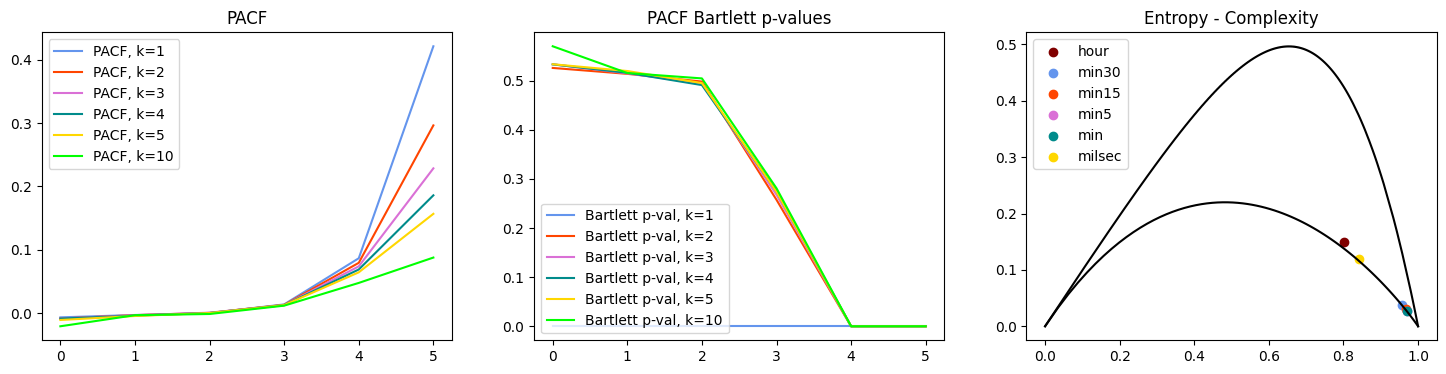

SBER s


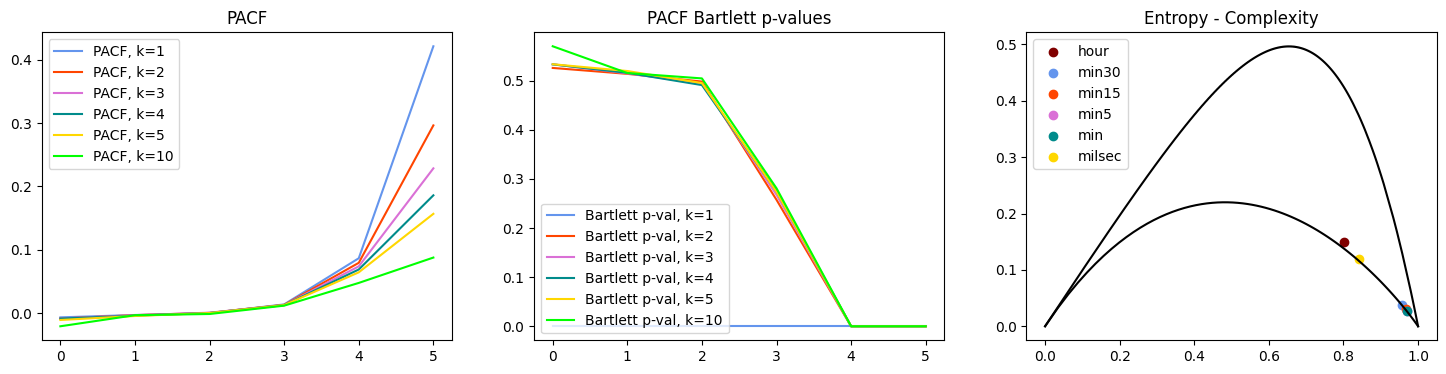

TRUR b


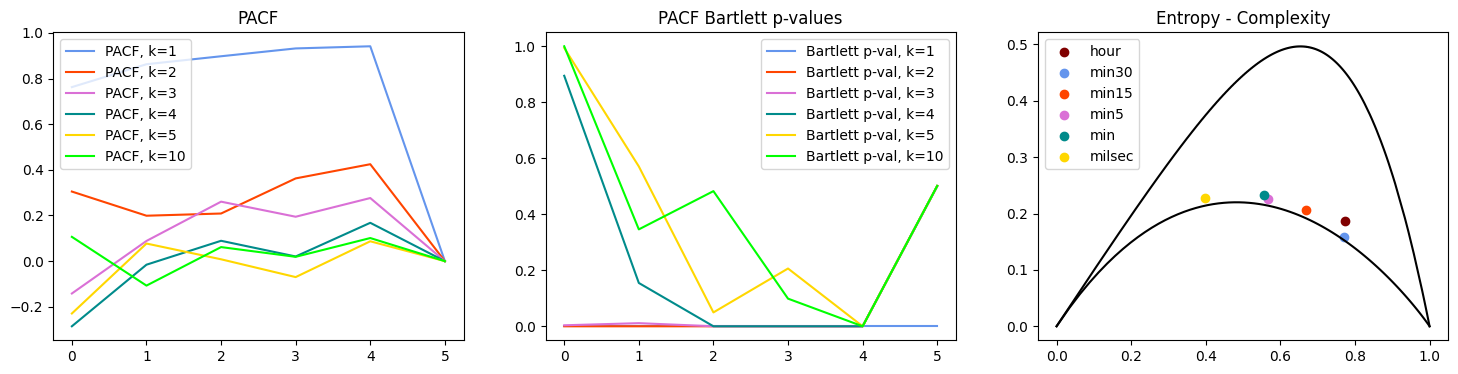

TRUR s


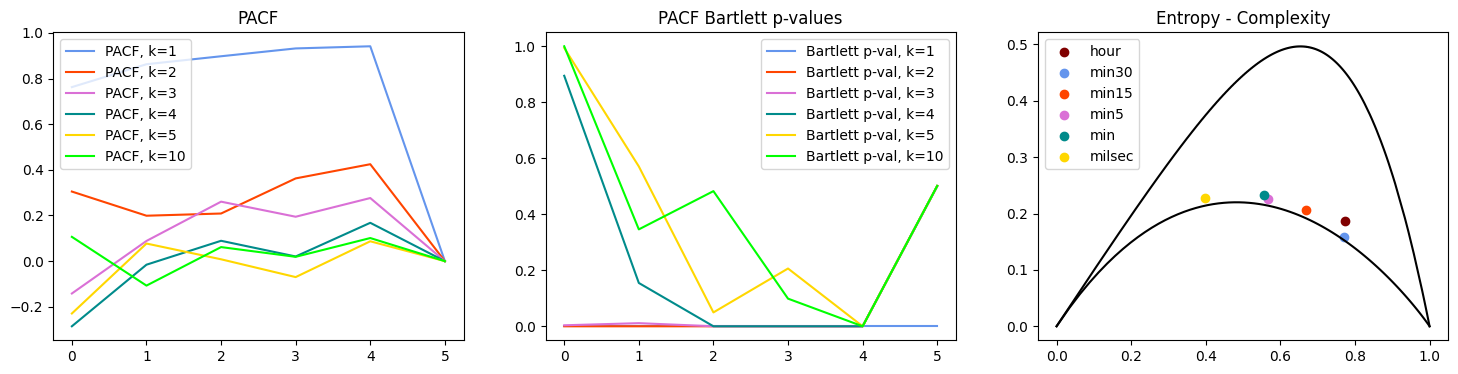

GAZP b


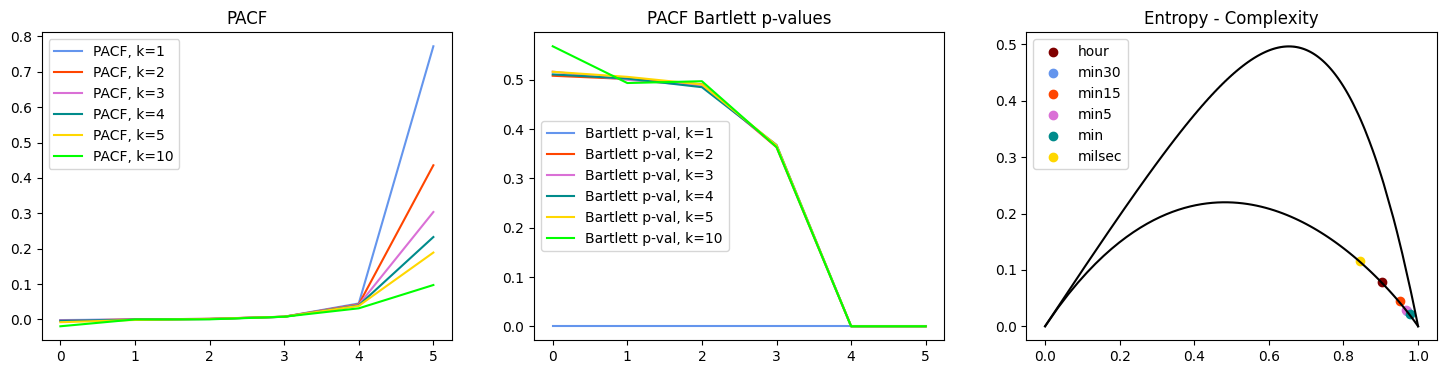

GAZP s


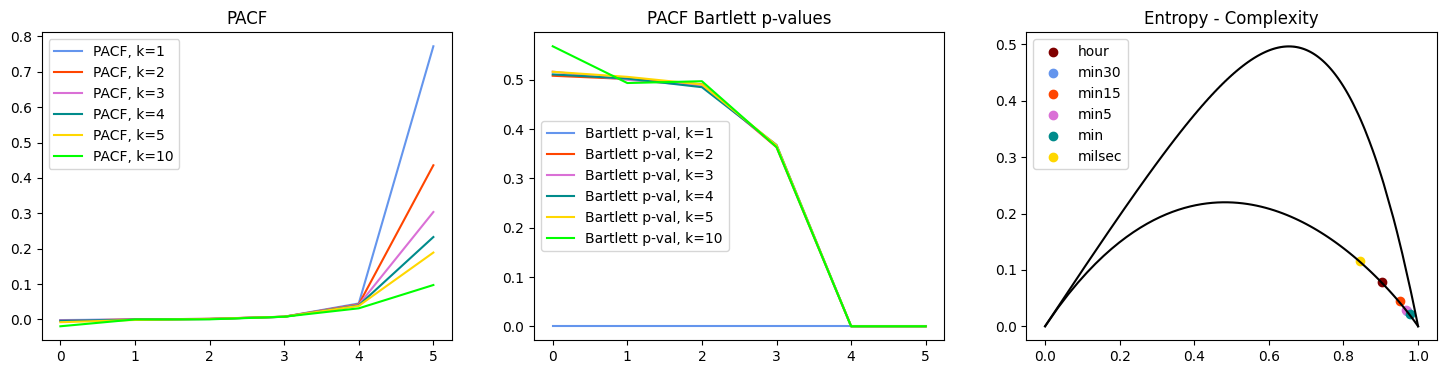

SBERP b


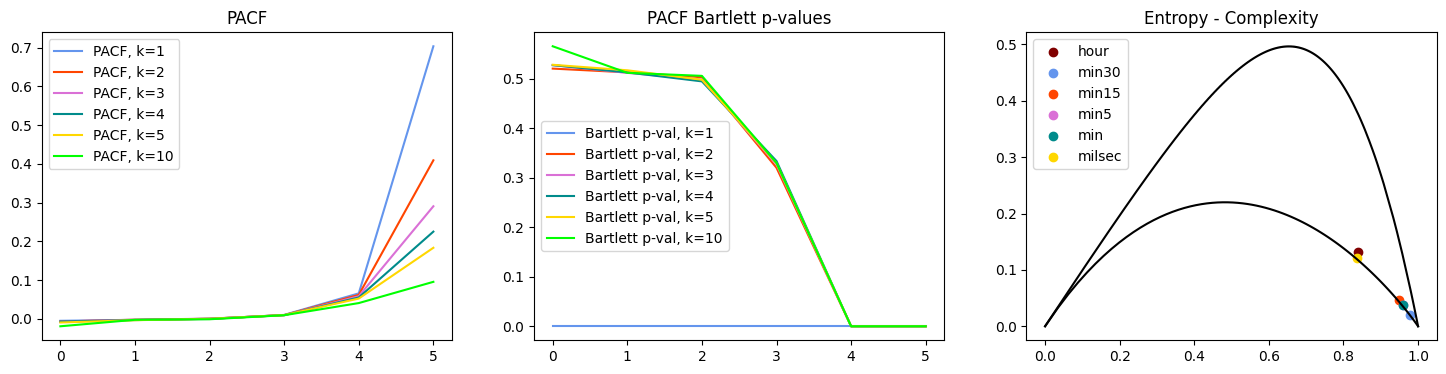

SBERP s


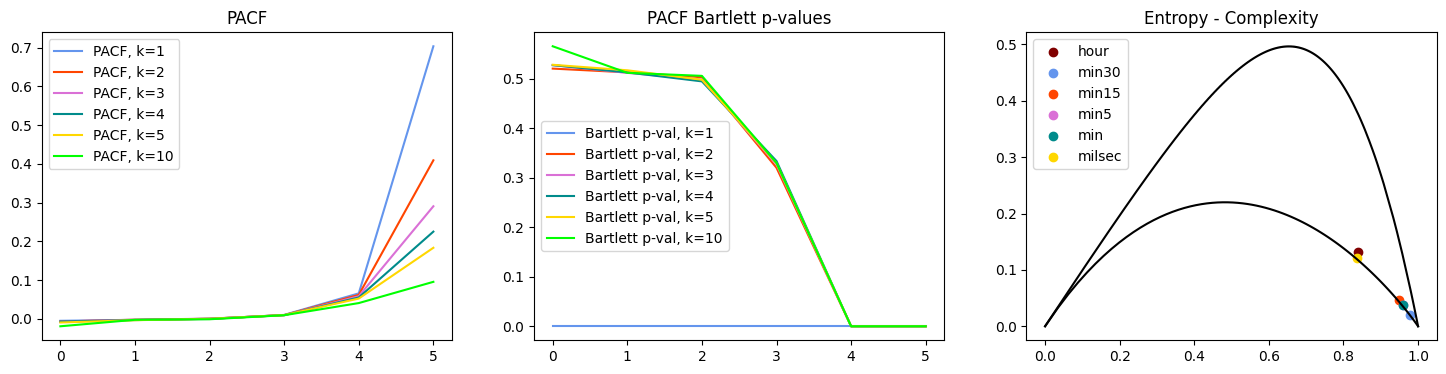

LKOH b


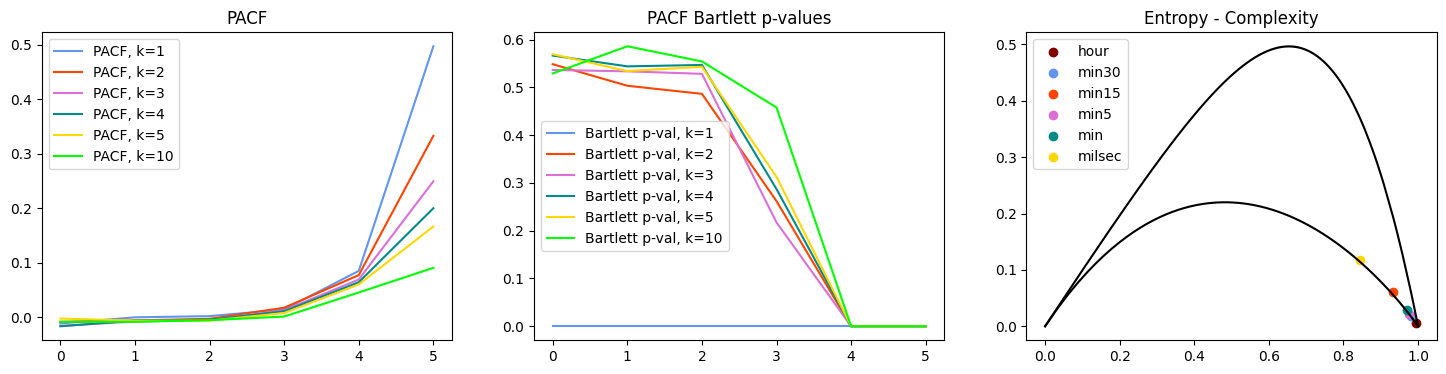

LKOH s


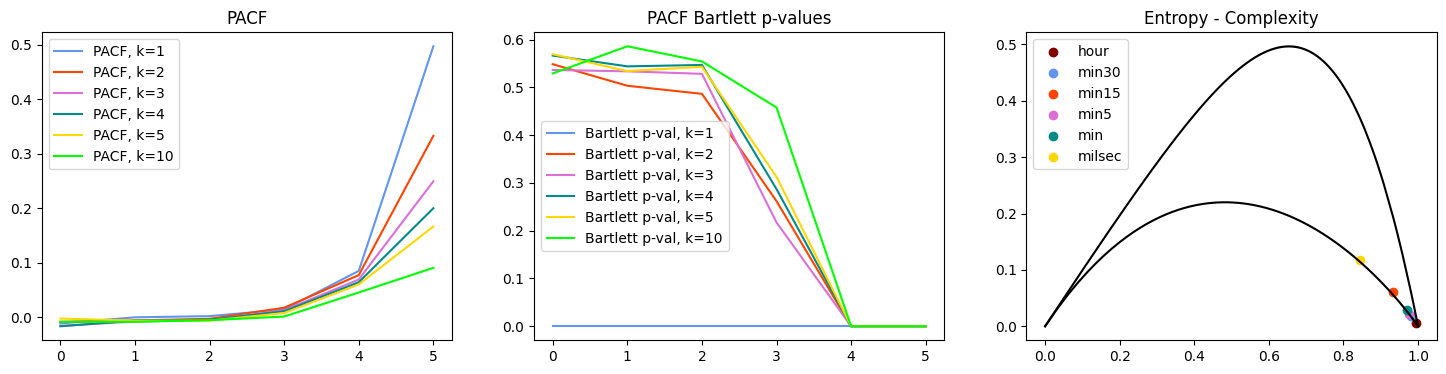

YNDX b


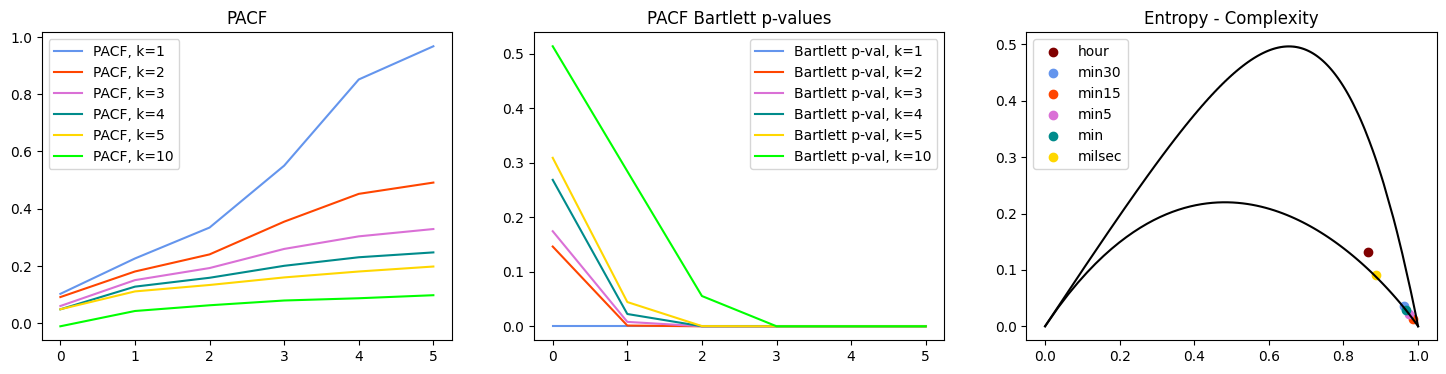

YNDX s


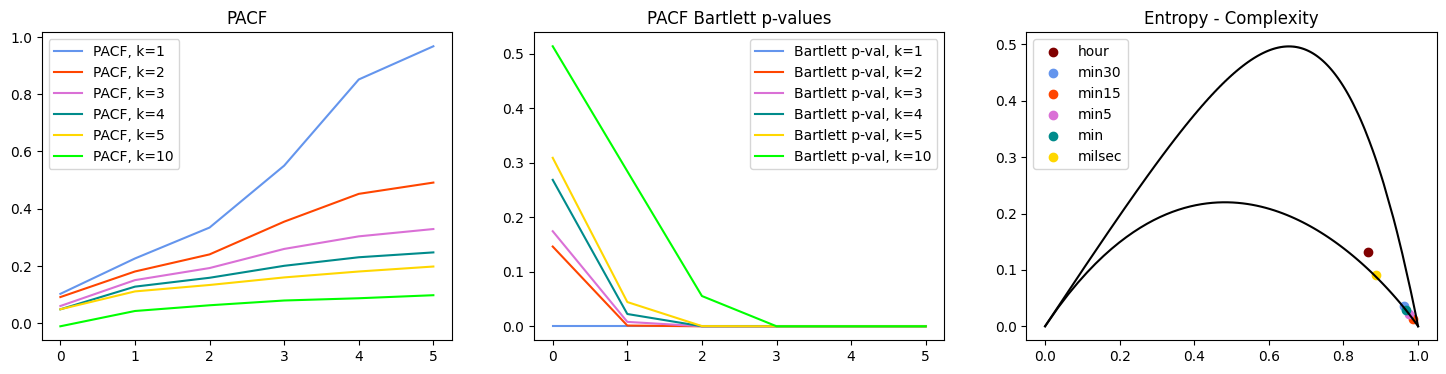

VTBR b


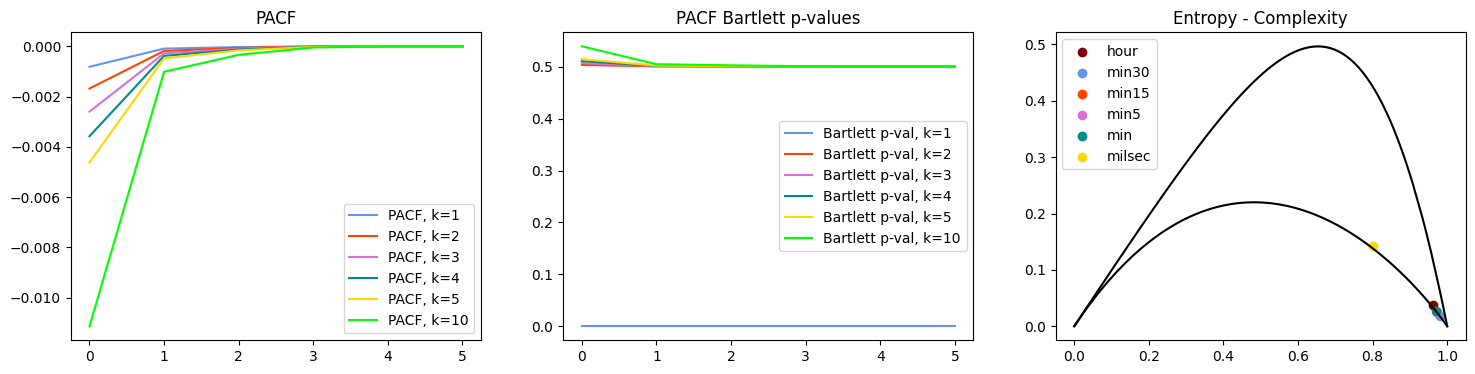

VTBR s


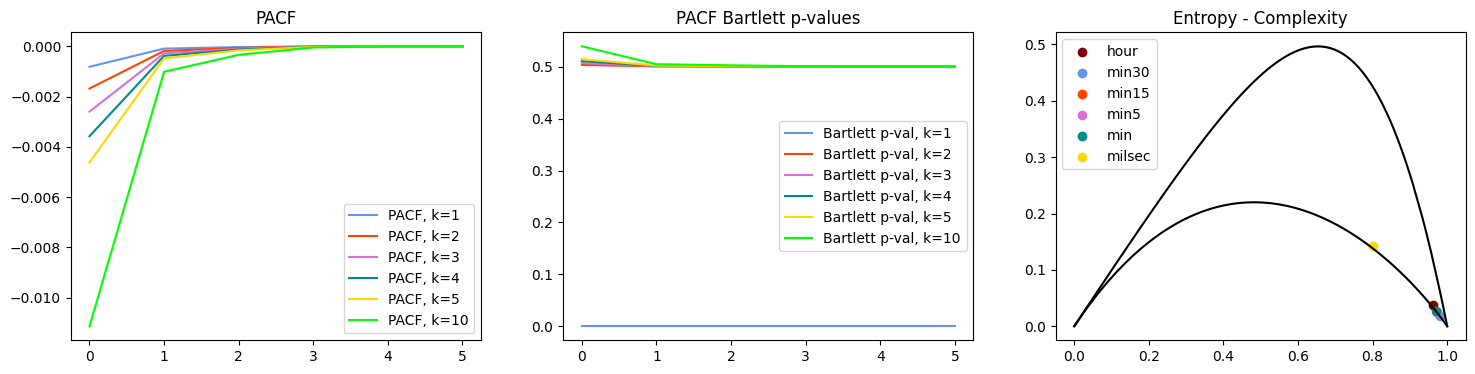

TCSG b


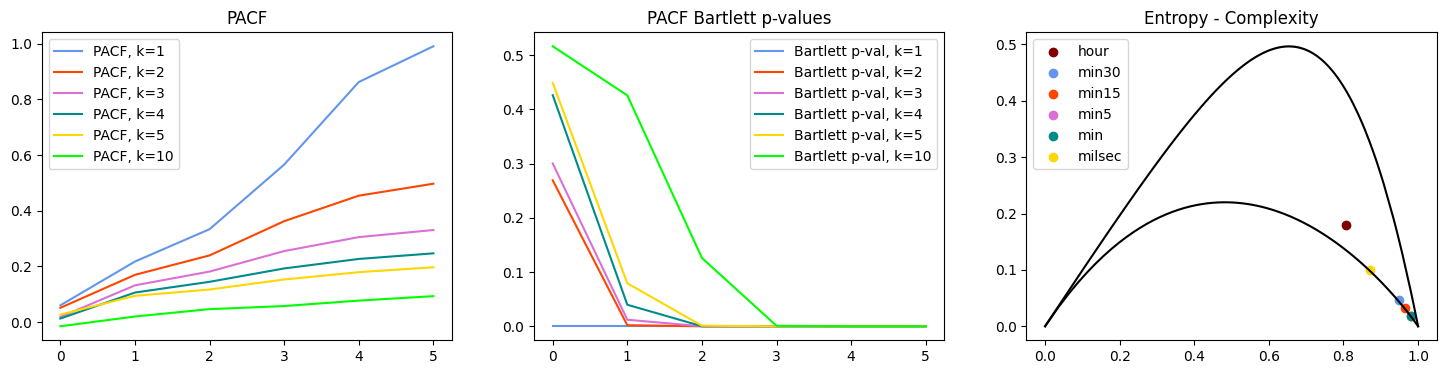

TCSG s


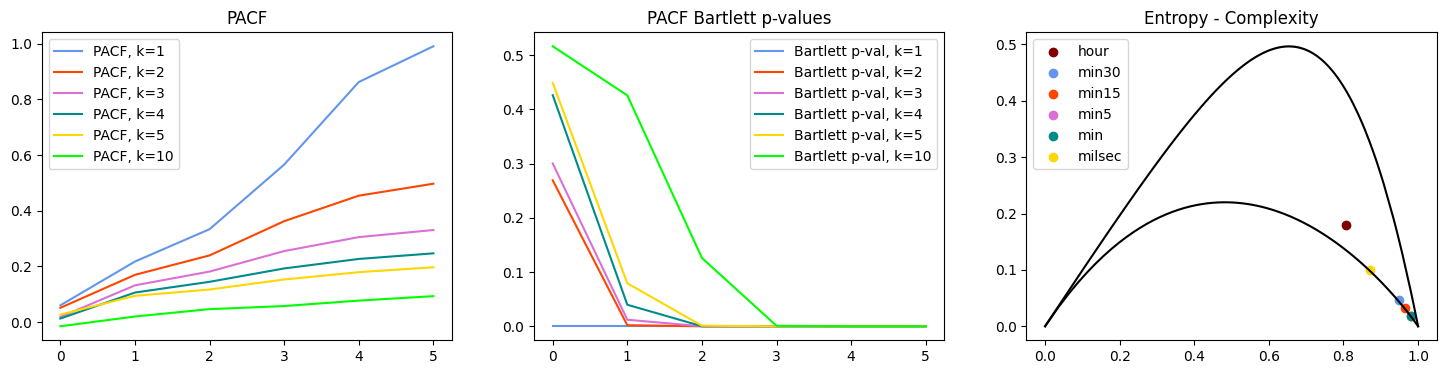

NVTK b


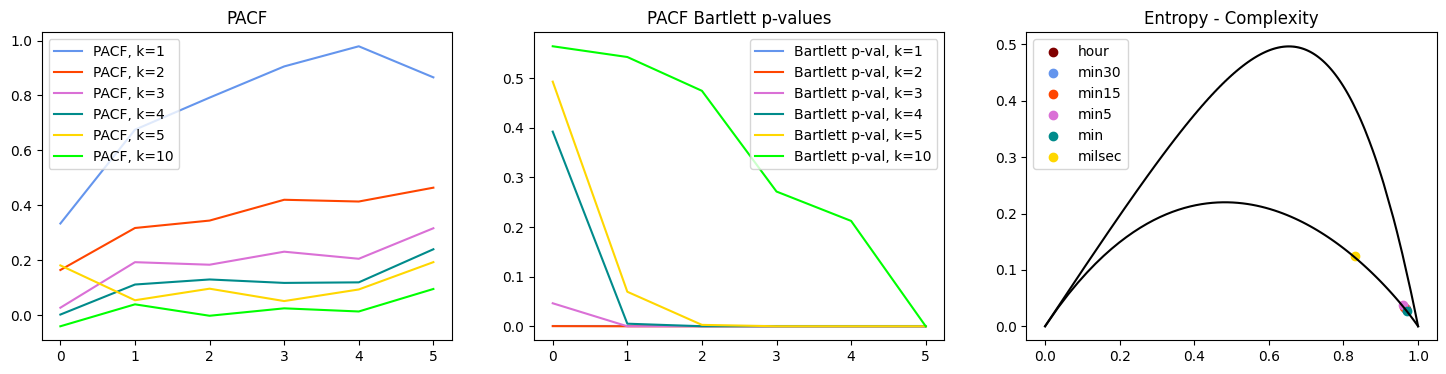

NVTK s


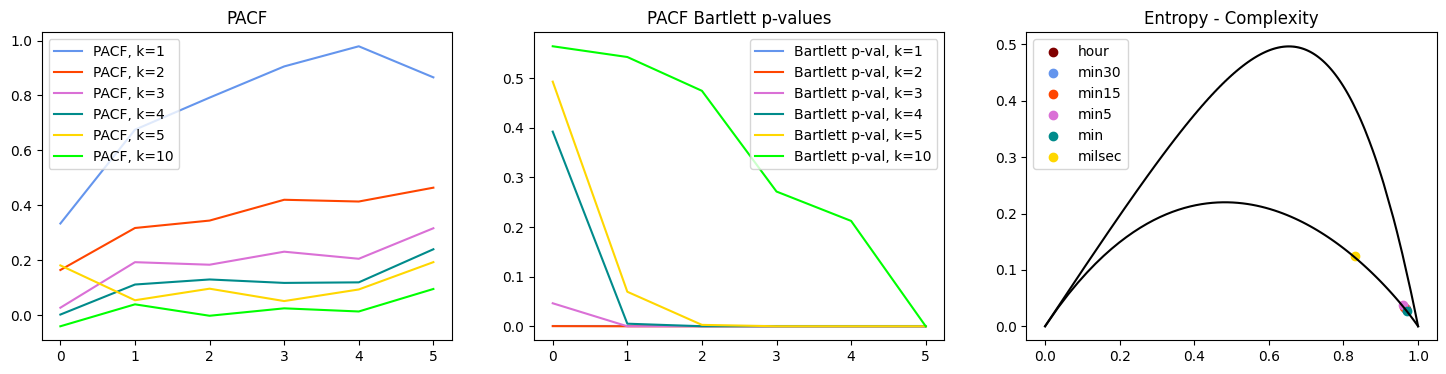

ROSN b


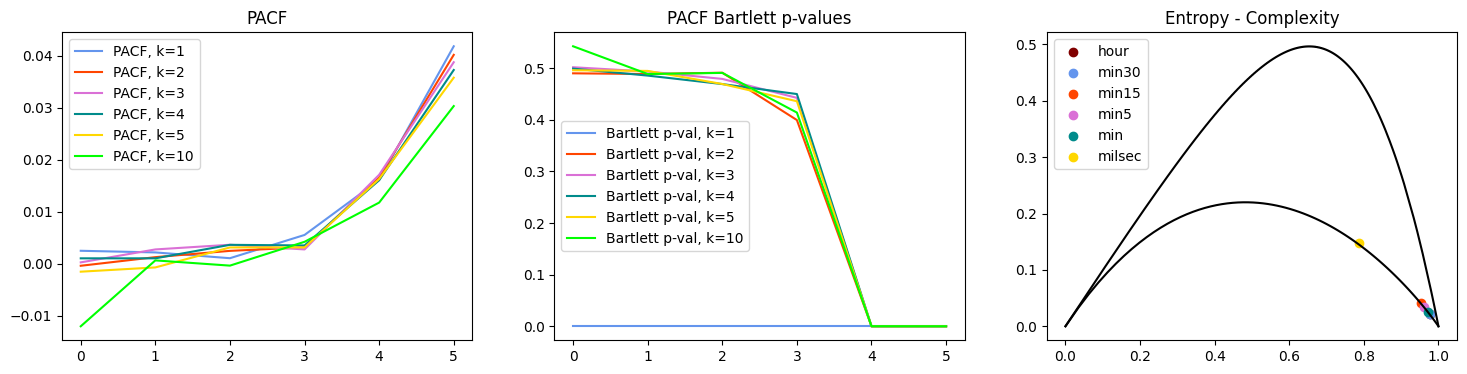

ROSN s


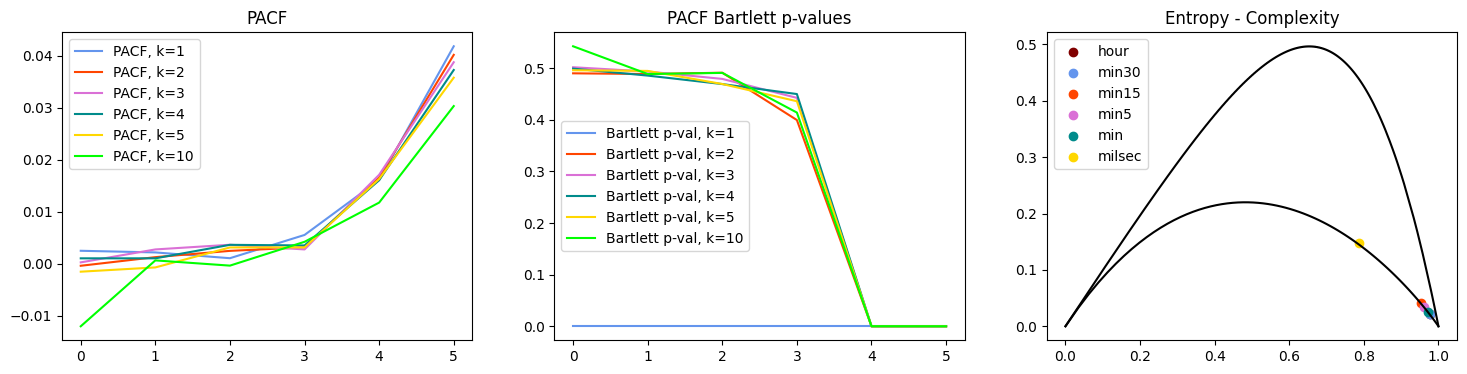

In [2]:
for seccode in ['SBER', 'TRUR', 'GAZP', 'SBERP', 'LKOH', 'YNDX', 'VTBR', 'TCSG', 'NVTK', 'ROSN']:
    for b_or_s in ['b', 's']:
        print(seccode, b_or_s)
        s2n = signal2noise(seccode=[seccode, b_or_s])
        s2n.plot()

In [ ]:
# 10 sec, 1 sec, 100 mil, 10 mil